# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

The problem statement is to predict used car pricing, given its features. The dataset includes listing of used cars with their many features as well as price. A regression model need to build to predict the pricing of a used car that is needs to be priced for selling.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

For data understanding, an exploratory data analysis will be done first. This will include previewing the data columns, sample rows, data types and descriptive statistics. After that, we will evaluate the distribution of the data columns identifying any outliers. Finally, we will look into nulls in various columns and use relevant imputation strategy. 

In [5]:
# import pandas, plotting and sklearn packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_error, r2_score

In [6]:
#zip the data file for ease of uploading to github 
import zipfile
with zipfile.ZipFile('data/vehicles.csv.zip', 'r') as zip_ref:
    # List the contents of the zip file
    print(zip_ref.namelist())

    # Extract all files to the current directory
    zip_ref.extractall()

    # Extract a specific file
    zip_ref.extract('vehicles.csv')

['vehicles.csv', '__MACOSX/._vehicles.csv']


In [7]:
# load the dataset
cars = pd.read_csv("vehicles.csv")

In [8]:
cars.sample(5)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
118361,7314286405,tampa bay area,29556,2018.0,volkswagen,atlas,NaN,6 cylinders,gas,44876.0,clean,automatic,NaN,4wd,full-size,SUV,white,fl
152532,7309315233,indianapolis,13990,2013.0,ford,c-max hybrid se wagon 4d,good,NaN,other,30998.0,clean,other,1FADP5AU7DL534960,fwd,NaN,wagon,white,in
7877,7311916610,fairbanks,3995,1984.0,chevrolet,k5 blazer,good,8 cylinders,gas,32000.0,clean,automatic,NaN,4wd,full-size,pickup,black,ak
22076,7311870192,bakersfield,27000,2020.0,ford,explorer,like new,4 cylinders,gas,7800.0,salvage,automatic,NaN,NaN,full-size,SUV,grey,ca
41658,7316069914,orange county,4000,2000.0,volvo,v70r,fair,5 cylinders,gas,274800.0,clean,automatic,NaN,4wd,full-size,wagon,silver,ca


In [9]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

#### Observations I
- The dataset has 17 features and price columns and over 420K rows.
- 14 of the independent features are object while id, VIN, odometer and year are the only numerical fields.
- "id", "VIN" columns can be dropped from analysis since they will not impact a pricing model.

In [10]:
# ID and VIN columns would not be useful for price modeling. Removing them here.
cars = cars.drop(columns = ["id", "VIN"])

In [11]:
#distribution of numerical columns
cars.describe()

,price,year,odometer
count,4.268800e+05,425675.000000,4.224800e+05
mean,7.519903e+04,2011.235191,9.804333e+04
std,1.218228e+07,9.452120,2.138815e+05
min,0.000000e+00,1900.000000,0.000000e+00
25%,5.900000e+03,2008.000000,3.770400e+04
50%,1.395000e+04,2013.000000,8.554800e+04
75%,2.648575e+04,2017.000000,1.335425e+05
max,3.736929e+09,2022.000000,1.000000e+07


<Axes: ylabel='Count'>

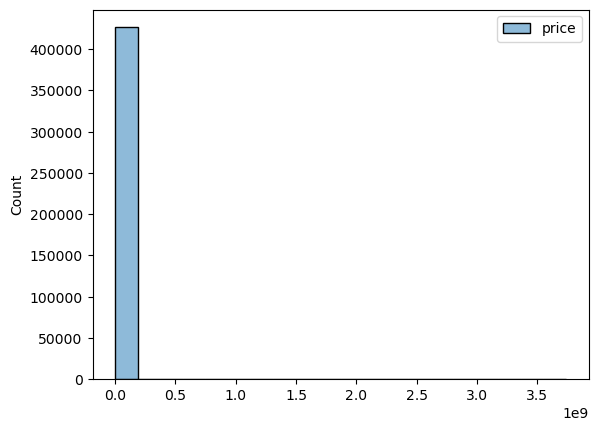

In [12]:
# distribution of price 
sns.histplot(cars[["price"]], bins = 20)


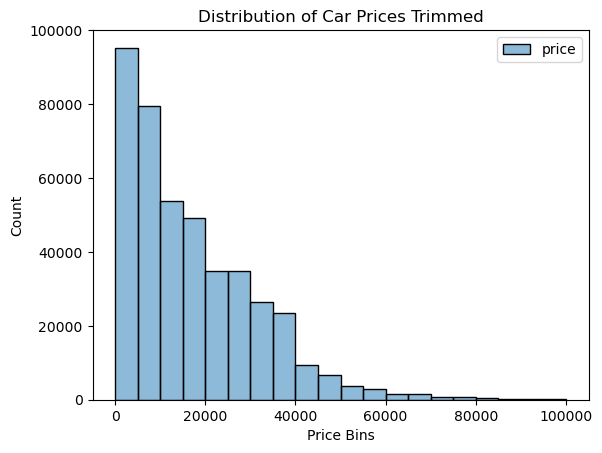

In [13]:
# price has large number of higher end outliers. trimming to view distribution of price 
sns.histplot(cars[["price"]].query('price < 100000'), bins = 20)
plt.xlabel("Price Bins")
plt.title("Distribution of Car Prices Trimmed")
plt.show();

In [14]:
# price > 100000 have only handful of data points. Removing these and price equal to 0
cars = cars.query('price < 100000 and price > 0')

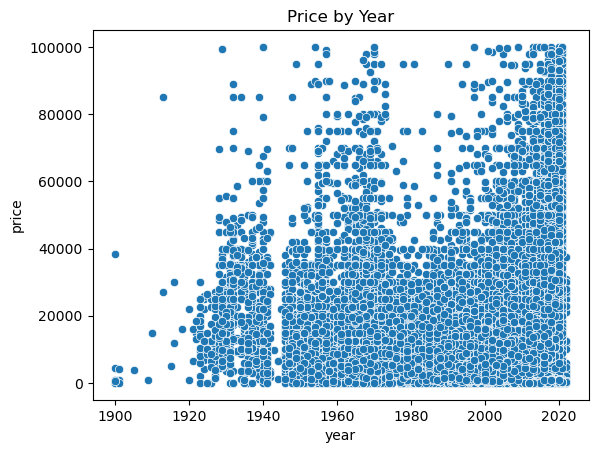

In [15]:
# price by year
sns.scatterplot(data=cars, x= "year", y = "price")
plt.title("Price by Year");


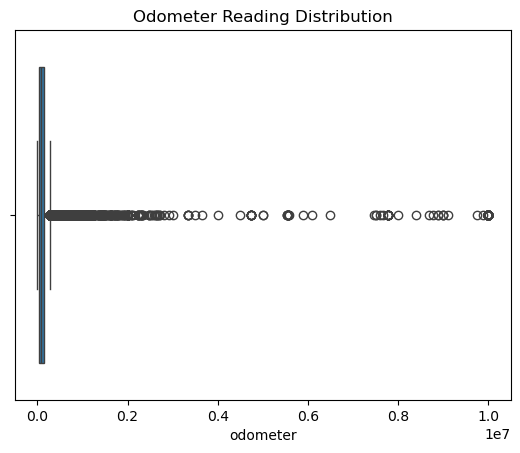

In [16]:
# odometer reading distribution
plt.title("Odometer Reading Distribution");
sns.boxplot(x = cars["odometer"])
plt.show()

(0.0, 400000.0)

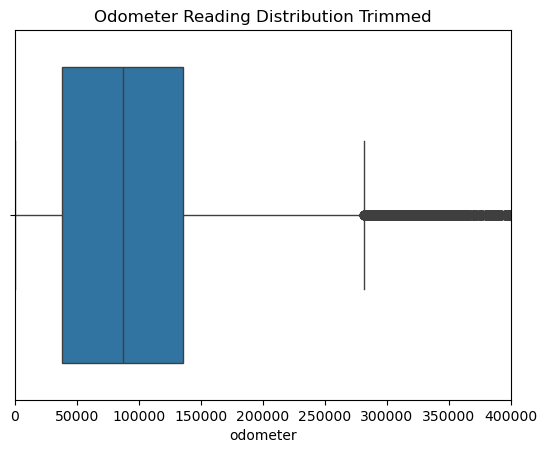

In [17]:
# odometer reading has large trail of outliers at higher end. trimming to get upper end box limit
plt.title("Odometer Reading Distribution Trimmed");
sns.boxplot(x = cars["odometer"])
plt.xlim(0, 400000)

In [18]:
# keeping odometer between 0 and 275000 and year above 1920
cars = cars.query('odometer < 275000 and odometer > 0 and year > 1920')

In [19]:
# check for nulls as percent of the total rows
print("Ratio of nulls in each column")
cars.isna().mean()

Ratio of nulls in each column


region          0.000000
price           0.000000
year            0.000000
manufacturer    0.035437
model           0.011295
condition       0.382692
cylinders       0.407968
fuel            0.005425
odometer        0.000000
title_status    0.018083
transmission    0.003906
drive           0.304495
size            0.717644
type            0.216044
paint_color     0.295539
state           0.000000
dtype: float64

In [20]:
# Dropping "size" columns because it has greater than 70% nulls and cannot be imputed effectively.
cars = cars.drop(columns = "size")

#### Observations II 
- Descriptive statistics of numeric columns highlights outliers of lower and upper end of price and odometer. Outlier trimming required.
- Price of 0 should be removed. Price above 80,000 also can be removed as outliers. Price distrbution is skewed. Using log of price may improve model.
- Lower end of year of 1900 seems incorrect. Removing 1920 and below.
- Odometer reading of 0 seems invalid. There are a number of outlier above 275,000. Trimming the column with these limits.
- There are number of columns with a high rate of nulls. "size" column with over 70% nulls is being excluded since any imputation does not seem like a good option.

In [21]:
# drop duplicates
cars = cars.drop_duplicates()
cars.shape

(336484, 15)

In [22]:
# split the categorical columns into 2 separate groups of low and high cardinality and a separate set for numerical columns 

low_cat = ["fuel", "drive", "cylinders", "title_status", "condition", "transmission"]
high_cat = ["paint_color", "type", "region", "state", "manufacturer", "model"]
num_col = ["odometer", "year"]

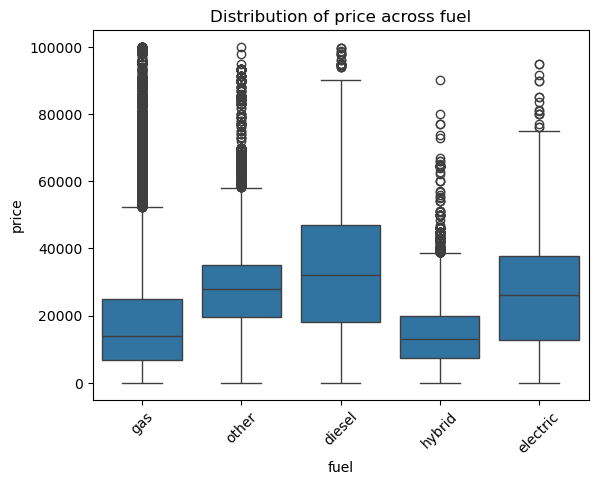

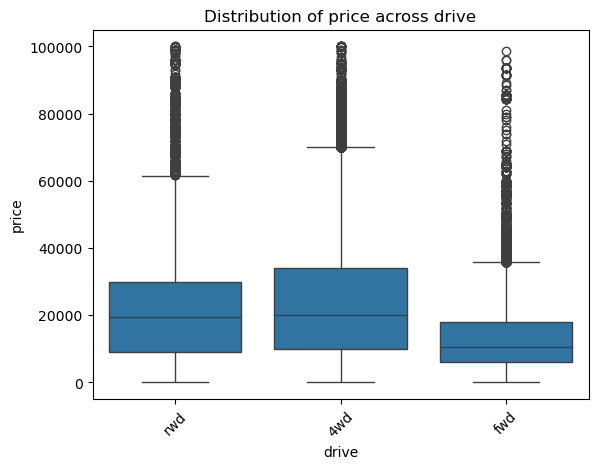

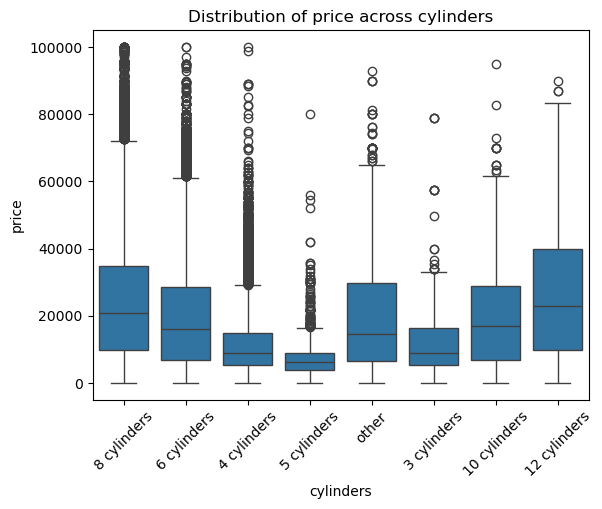

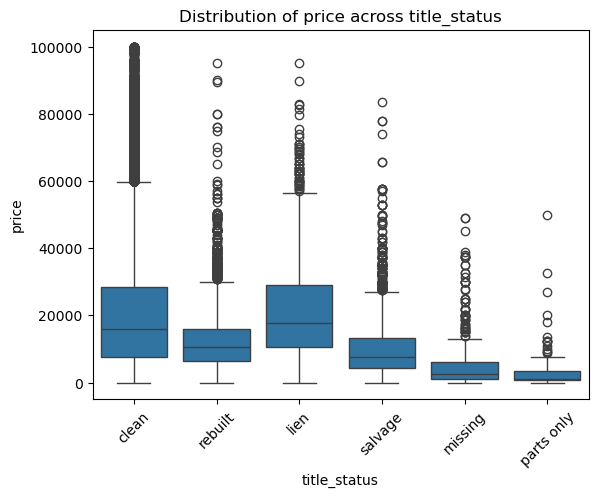

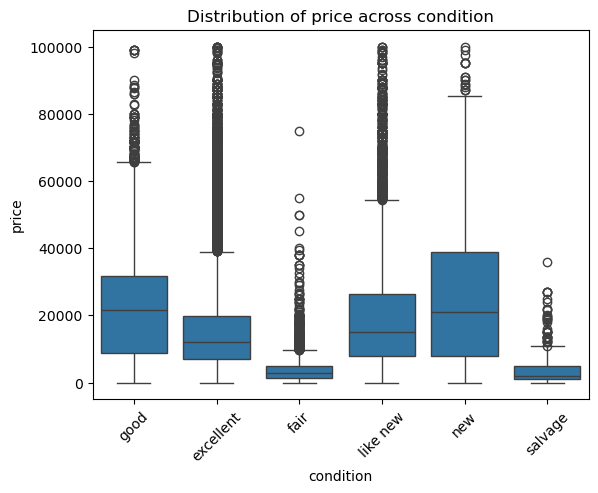

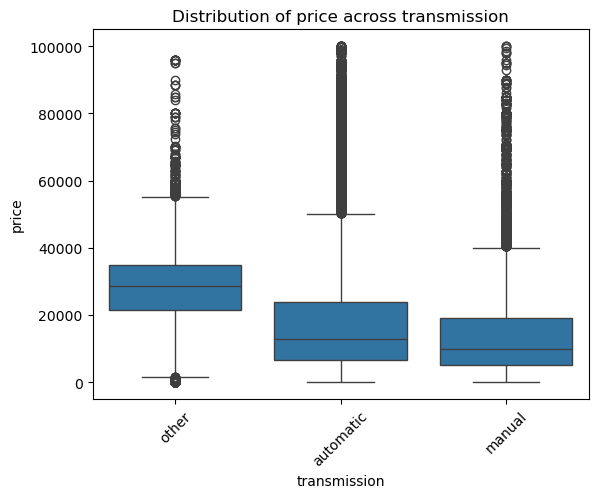

In [23]:
# distrbution of categorical columns with small cardinality  
for i, col in enumerate(low_cat):
    sns.boxplot(data = cars, x = col, y = "price")
    plt.title(f'Distribution of price across {col}')
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.ylabel("price")
    plt.show()


#### Observations III 
- Price is higher for diesel fuel type than other fuel types.
- fwd drive has lower price than other types.
- 12 cylinder cars are pricier and wider in range, 5 cylinders are the lowest price.
- title_status of lien has large range and highest price compared to other status. Similarly, new condition has the highest price and salvage the lowest.
- Upper bound of best cars is at 90,000. Trimmed price down to 90,000

In [24]:
# price less than 90,000
cars = cars.query('price < 90000')

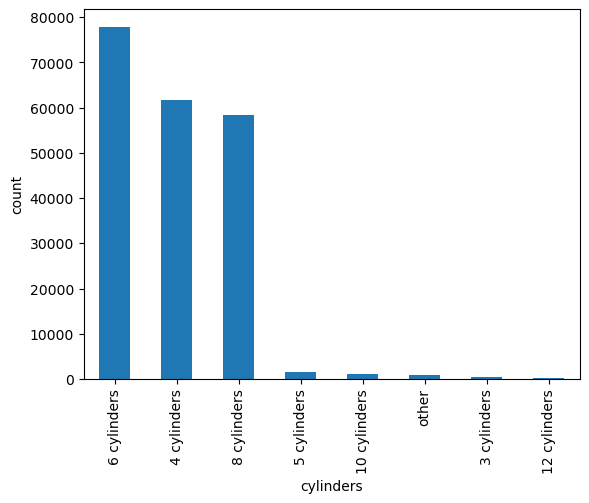

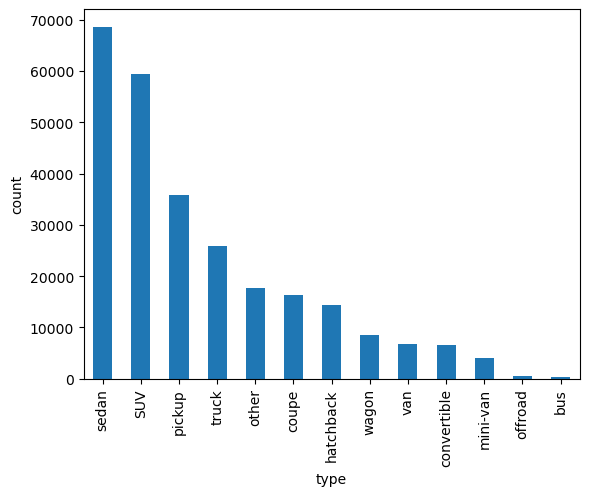

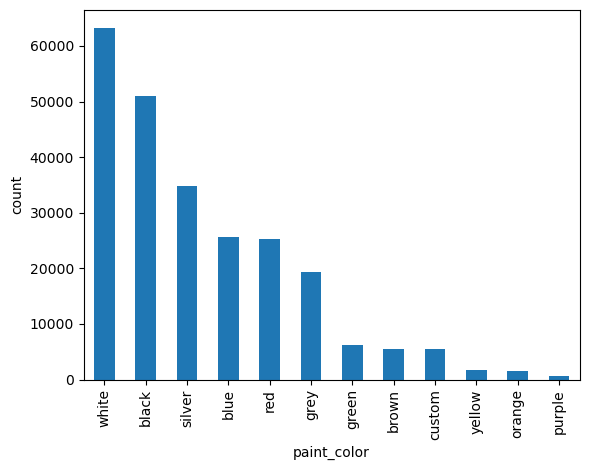

In [25]:
# count by category for other columns with high cardinality. Potential to group lower frequency categories into "other" category
cat_col_2 = ["cylinders", "type", "paint_color"]
for col in cat_col_2: 
    cars[col].value_counts().plot(kind = "bar", ylabel = "count")
    plt.show()

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

In [26]:
# create a dataset with just numerical columns for baseline model, one with numerical and lo cardinality rows and third with all rows
cars_base = cars[num_col]
cars_trim = cars[num_col + low_cat]
cars_all = cars[num_col + low_cat + high_cat]

In [27]:
#check on base nulls 
cars_base.isna().mean()

odometer    0.0
year        0.0
dtype: float64

In [28]:
# title_status and condition columns have similar categories for the car condition. condition column has over 38% nulls. Removing this and keeping title_status 
cars_trim = cars_trim.drop(columns = ["condition"])

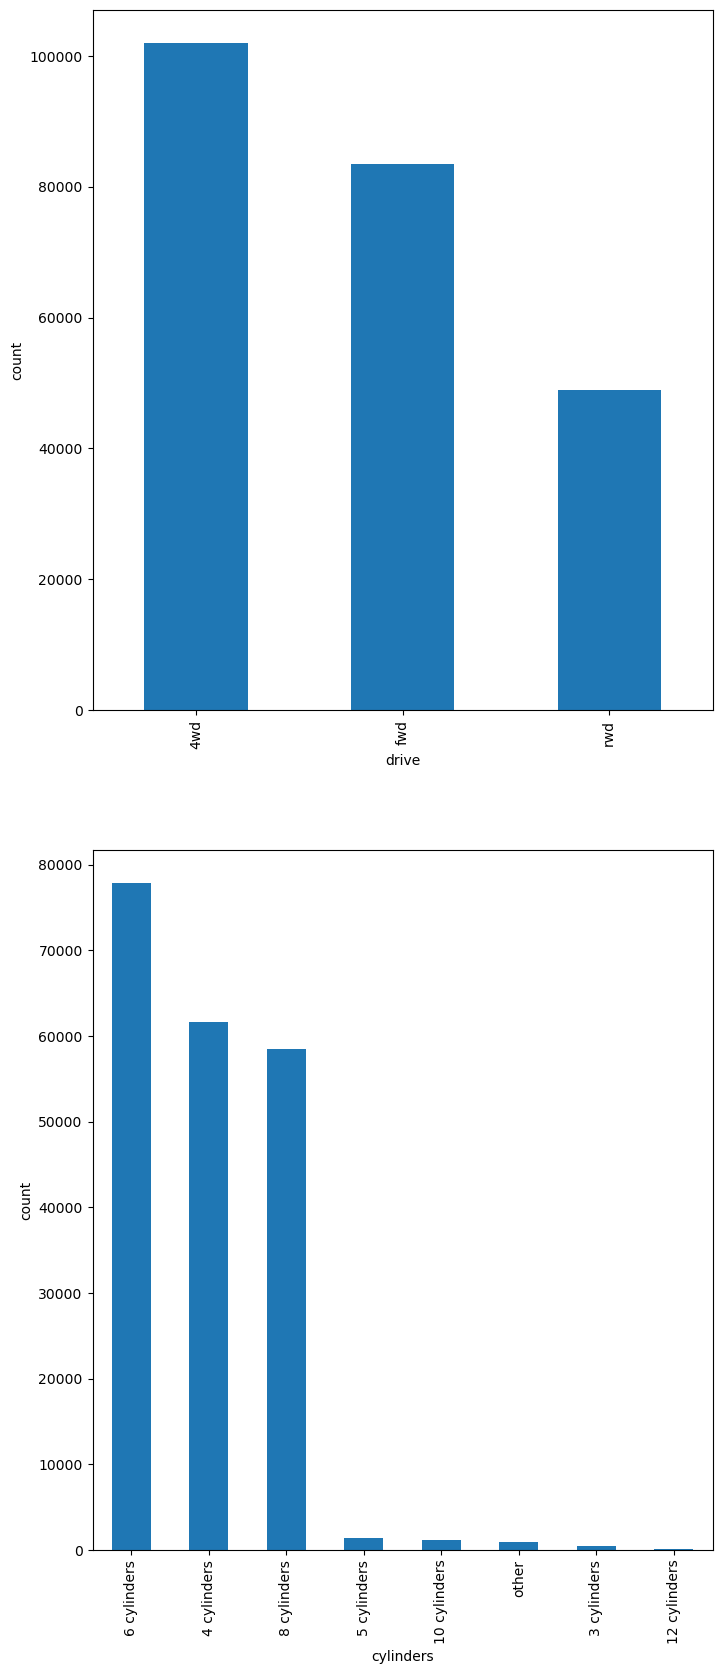

In [29]:
# Evaluate the high null columns
# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 20))
r = 0
for col in ["drive", "cylinders"]:
  cars_trim[col].value_counts().plot(kind = "bar", ax = axes[r], ylabel = "count")
  r += 1


In [30]:
# cyclinder types 5, 10, other, 3 and 12 have very few data points. group them into "other" 
cyl_other = ["5 cylinders", "10 cylinders", "other", "3 cylinders", "12 cylinders"]

cars_trim['cylinders'] = cars_trim['cylinders'].replace(to_replace=[x for x in cars_trim['cylinders'].unique() if x in cyl_other], value='other')


In [31]:
cars_trim.isna().mean()

odometer        0.000000
year            0.000000
fuel            0.004913
drive           0.302690
cylinders       0.399132
title_status    0.016734
transmission    0.003744
dtype: float64

In [32]:
# training and test for baseline and trim and all
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(cars_base, cars["price"], test_size=0.3, random_state=22)
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(cars_trim, cars["price"], test_size=0.3, random_state=22)

In [33]:
# Steps to take care of null values 
# For columns with few nulls - transmission, title, odometer, fuel, model, manufacturer and year - fill with the most common values
few_null_cols = ["transmission", "title_status", "fuel"]

for col in few_null_cols:
    X_train_t[col] = X_train_t[col].fillna(X_train_t[col].mode()[0])
    X_test_t[col] = X_test_t[col].fillna(X_test_t[col].mode()[0])


In [34]:
# impute nulls as a missing category value in each categorical column
for col in ["drive", "cylinders"]:
    X_train_t[col] = X_train_t[col].fillna("missing")
    X_test_t[col] = X_test_t[col].fillna("missing")


In [35]:
# manufacturer, model , state and region have a very large number of categories. Ignoring them from model
cars_all = cars_all.drop(columns = ["manufacturer", "model", "region", "state", "condition"])


In [36]:
cars_all.isna().mean()

odometer        0.000000
year            0.000000
fuel            0.004913
drive           0.302690
cylinders       0.399132
title_status    0.016734
transmission    0.003744
paint_color     0.285266
type            0.212098
dtype: float64

In [37]:
# Grouping trailing categories as "other" in type and paint_color, cylinders 
# type off road and bus are grouped with other
type_other = ["offroad", "bus", "other"]
cars_all['type'] = cars_all['type'].replace(to_replace=[x for x in cars_all['type'].unique() if x in type_other], value='other')

# color yellow, orange, purple are grouped as other
color_other = ["yellow", "purple", "orange"]

cars_all['paint_color'] = cars_all['paint_color'].replace(to_replace=[x for x in cars_all['paint_color'].unique() if x in color_other], value='other')

# cyclinder types 5, 10, other, 3 and 12 have very few data points. group them into "other" 
cars_all['cylinders'] = cars_all['cylinders'].replace(to_replace=[x for x in cars_all['cylinders'].unique() if x in cyl_other], value='other')


In [38]:
# impute nulls as a missing category value in each categorical column
for col in ["drive", "cylinders", "type", "paint_color"]:
    cars_all[col] = cars_all[col].fillna("missing")


In [39]:
cars_all.isna().mean()

odometer        0.000000
year            0.000000
fuel            0.004913
drive           0.000000
cylinders       0.000000
title_status    0.016734
transmission    0.003744
paint_color     0.000000
type            0.000000
dtype: float64

In [40]:
# training and test sets after removing condition, manufacturer, model, region, state column 
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(cars_all, cars["price"], test_size=0.3, random_state=22)

In [41]:
#impute for nulls
# low % nulls with higher frequency value 
for col in few_null_cols:
    X_train_a[col] = X_train_a[col].fillna(X_train_a[col].mode()[0])
    X_test_a[col] = X_test_a[col].fillna(X_test_a[col].mode()[0])


In [42]:
X_train_a.isna().mean()

odometer        0.0
year            0.0
fuel            0.0
drive           0.0
cylinders       0.0
title_status    0.0
transmission    0.0
paint_color     0.0
type            0.0
dtype: float64

##### Data Preparation 
- Baseline dataset is created with just numerical columns, additional set including low cardinality columns and final set with all columns
- Columns with small percent (< 10%) of nulls are filled with most frequent value for that column
- For columns with > 20% of nulls, the nulls are grouped as a "missing" value instead of replacig with most frequent value.
- High cardinality columns model, manufacturer, region, state are ignored for now.

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

Modeling Steps 
- Column transformer made with numerical columns normalized and categorical columns dummified using OneHotEncoder
- Polynomial features optimized with no overfitting
- Cross validation used for regularization paramter optimization
- Model error and R2 score compared to base model

In [43]:
# create transformer for scaling and onehoteencoding the categorical columns
def model_def (df, model):
    cat_columns = df.select_dtypes(include = object).columns
    num_columns = df.select_dtypes(exclude = object).columns

    num_pipe = Pipeline([
        ("scale", StandardScaler()), 
    ])

    cat_pipe = Pipeline([
        ("onehot", OneHotEncoder())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_pipe, num_columns),
            ('cat', cat_pipe, cat_columns)
        ])

    model = Pipeline([
     ( "prep", preprocessor),
     ( "poly", PolynomialFeatures(include_bias=False)),
     ( "model",model)
    ])

    return model

In [44]:
# find best polynomial degree for linear regresssion
def grid_lin(dftrain, ytrain, degree_list): 
    grid = GridSearchCV(estimator=model_def(dftrain, LinearRegression()), param_grid={'poly__degree': degree_list}, scoring = "neg_root_mean_squared_error", cv = 5)
    grid.fit(dftrain, ytrain)
    best_model = grid.best_estimator_
    print(f"Best model params - {grid.best_params_}")
    return best_model

In [45]:
# find best polynomial degree , best alpha for Ridge 
def grid_ridge(dftrain, ytrain, degree_list, alpha_list): 
    grid = GridSearchCV(estimator=model_def(dftrain, Ridge()), param_grid={'poly__degree': degree_list, 'model__alpha' : alpha_list}, scoring = "neg_root_mean_squared_error", cv = 5)
    grid.fit(dftrain, ytrain)
    best_model = grid.best_estimator_
    print(f"Best model params - {grid.best_params_}")
    return best_model

In [46]:
# find best polynomial degree , best alpha for Lasso 
def grid_lasso(dftrain, ytrain, degree_list, alpha_list): 
    grid = GridSearchCV(estimator=model_def(dftrain, Lasso(tol = 1, max_iter = 8000)), param_grid={'poly__degree': degree_list, 'model__alpha' : alpha_list}, scoring = "neg_root_mean_squared_error", cv = 5)
    grid.fit(dftrain, ytrain)
    best_model = grid.best_estimator_
    print(f"Best model params - {grid.best_params_}")
    return best_model

In [47]:
# function to calculate model error and r2 score 
def score(model, dftrain, dftest, ytrain, ytest): 
    # fit the model
    model.fit(dftrain, ytrain)
    # predictions
    preds_train = model.predict(dftrain)
    preds_test = model.predict(dftest)
    #rmse errors and r2 score
    rmse_train = root_mean_squared_error(preds_train, ytrain)
    rmse_test = root_mean_squared_error(preds_test, ytest)
    r2 = r2_score(ytest, preds_test)
    print(f"Best model - RMSE for training set is {round(rmse_train, 2)}, for test set is {round(rmse_test, 2)}. Price prediction is off by ${round(rmse_test, 0)}")
    print(f"R2 score for the best model is {round(r2, 2)}. {round(r2*100, 0)}% data points are explained by the model")

In [48]:
# get feature names 
def get_feature_names(best_model):
    prep_cols = best_model.named_steps["prep"].get_feature_names_out()
    df_coefs = pd.DataFrame(best_model.named_steps["model"].coef_, best_model.named_steps["poly"].get_feature_names_out(input_features=prep_cols), columns = ["Coefficients"])
    return df_coefs.abs().sort_values(by = "Coefficients", ascending=False).head()

In [49]:
#create baseline model 
print("Baseline model - LinearRegression with only numerical columns =========")

best_model_linreg = grid_lin(X_train_b, y_train_b, [1])
score(best_model_linreg, X_train_b, X_test_b, y_train_b, y_test_b)


Baseline model - LinearRegression with only numerical columns =========
Best model params - {'poly__degree': 1}
Best model - RMSE for training set is 11747.66, for test set is 11746.84. Price prediction is off by $11747.0
R2 score for the best model is 0.32. 32.0% data points are explained by the model


In [50]:
#baseline with log price 
print("Baseline model - LinearRegression with log price =========")
best_model_linreg = grid_lin(X_train_b, np.log(y_train_b), [1])
score(best_model_linreg, X_train_b, X_test_b, np.log(y_train_b), np.log(y_test_b))

Baseline model - LinearRegression with log price =========
Best model params - {'poly__degree': 1}
Best model - RMSE for training set is 1.05, for test set is 1.07. Price prediction is off by $1.0
R2 score for the best model is 0.19. 19.0% data points are explained by the model


In [51]:
# creating the combinations in model to try . Degree 3 taking a long time to compute. For this analysis, staying with max degree 2.
degree_list = [1,2]
alpha_list = [ 0.01, 1, 10, 100]

#### Intermediate dataset - Linear Regression, Ridge and Lasso optimization (degree 3 takes a long time to compute for categorical columns. Staying with degree 2 and comparing different regression models.)

In [52]:
# Linear Regression 
best_model_linreg = grid_lin(X_train_t, y_train_t, degree_list)
score(best_model_linreg, X_train_t, X_test_t, y_train_t, y_test_t)

Best model params - {'poly__degree': 2}
Best model - RMSE for training set is 8467.75, for test set is 8515.34. Price prediction is off by $8515.0
R2 score for the best model is 0.64. 64.0% data points are explained by the model


In [53]:
# Ridge Regression 
best_model_ridge = grid_ridge(X_train_t, y_train_t, degree_list, alpha_list)
score(best_model_ridge, X_train_t, X_test_t, y_train_t, y_test_t)

Best model params - {'model__alpha': 10, 'poly__degree': 2}
Best model - RMSE for training set is 8468.43, for test set is 8514.42. Price prediction is off by $8514.0
R2 score for the best model is 0.64. 64.0% data points are explained by the model


In [54]:
# Lasso Regression 
best_model_lasso = grid_lasso(X_train_t, y_train_t, degree_list, alpha_list)
score(best_model_lasso, X_train_t, X_test_t, y_train_t, y_test_t)

Best model params - {'model__alpha': 0.01, 'poly__degree': 2}
Best model - RMSE for training set is 8642.7, for test set is 8706.14. Price prediction is off by $8706.0
R2 score for the best model is 0.63. 63.0% data points are explained by the model


#### Complex dataset - Linear Regression

In [55]:
# Linear Regression 
best_model_linreg2 = grid_lin(X_train_a, y_train_a, degree_list)
score(best_model_linreg2, X_train_a, X_test_a, y_train_a, y_test_a)

Best model params - {'poly__degree': 2}
Best model - RMSE for training set is 8024.91, for test set is 8070.37. Price prediction is off by $8070.0
R2 score for the best model is 0.68. 68.0% data points are explained by the model


In [56]:
# Ridge Regression 
best_model_ridge2 = grid_ridge(X_train_a, y_train_a, degree_list, alpha_list)
score(best_model_ridge2, X_train_a, X_test_a, y_train_a, y_test_a)

Best model params - {'model__alpha': 10, 'poly__degree': 2}
Best model - RMSE for training set is 8026.33, for test set is 8069.16. Price prediction is off by $8069.0
R2 score for the best model is 0.68. 68.0% data points are explained by the model


In [57]:
# Lasso Regression 
best_model_lasso = grid_lasso(X_train_a, y_train_a, degree_list, alpha_list)
score(best_model_lasso, X_train_a, X_test_a, y_train_a, y_test_a)

Best model params - {'model__alpha': 0.01, 'poly__degree': 2}
Best model - RMSE for training set is 8203.34, for test set is 8268.57. Price prediction is off by $8269.0
R2 score for the best model is 0.66. 66.0% data points are explained by the model


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

# Results from the models 
Baseline model - 
LinearRegression with only numerical columns =========
RMSE for training set is 11747.66, for test set is 11746.84. Price prediction is off by $11747.0
R2 score for the best model is 0.32. 32.0% data points are explained by the model

with log of dependent column
Baseline model - LinearRegression with log price =========
RMSE for training set is 1.05, for test set is 1.07. Price prediction is off by $1.0
R2 score for the best model is 0.19. 19.0% data points are explained by the model

Log of pricing does not explain data points better than regular price.

Intermediate model -
Linear Regression -
Best model params - {'poly__degree': 2}
Best model - RMSE for training set is 8467.75, for test set is 8515.34. Price prediction is off by $8515.0
R2 score for the best model is 0.64. 64.0% data points are explained by the model

Ridge Regression - 
Best model params - {'model__alpha': 10, 'poly__degree': 2}
Best model - RMSE for training set is 8468.43, for test set is 8514.42. Price prediction is off by $8514.0
R2 score for the best model is 0.64. 64.0% data points are explained by the model

Lasso Regression -
Best model params - {'model__alpha': 0.01, 'poly__degree': 2}
Best model - RMSE for training set is 8642.7, for test set is 8706.14. Price prediction is off by $8706.0
R2 score for the best model is 0.63. 63.0% data points are explained by the model

Complex model -
Linear Regression -
Best model params - {'poly__degree': 2}
Best model - RMSE for training set is 8024.91, for test set is 8070.37. Price prediction is off by $8070.0
R2 score for the best model is 0.68. 68.0% data points are explained by the model

Ridge Regression -
Best model params - {'model__alpha': 10, 'poly__degree': 2}
Best model - RMSE for training set is 8026.33, for test set is 8069.16. Price prediction is off by $8069.0
R2 score for the best model is 0.68. 68.0% data points are explained by the model

Lasso Regression -
Best model params - {'model__alpha': 0.01, 'poly__degree': 2}
Best model - RMSE for training set is 8203.34, for test set is 8268.57. Price prediction is off by $8269.0
R2 score for the best model is 0.66. 66.0% data points are explained by the model


Best model - Ridge Regression with complex dataset

In [58]:
# get columns names and model coefficients
coefficients = best_model_ridge2.named_steps["model"].coef_
prep_cols = best_model_ridge2.named_steps["prep"].get_feature_names_out()
features = best_model_ridge2.named_steps["poly"].get_feature_names_out(prep_cols)
pd.DataFrame({"features": features, "coefficients" : coefficients}).sort_values(by = "coefficients", key=abs, ascending=False).head(10)

,features,coefficients
223,cat__fuel_electric cat__type_convertible,-6583.031034
193,cat__fuel_electric cat__drive_4wd,5795.534366
185,cat__fuel_diesel cat__type_sedan,-5494.713934
267,cat__fuel_gas cat__type_convertible,5488.619091
182,cat__fuel_diesel cat__type_missing,5315.214806
186,cat__fuel_diesel cat__type_truck,5310.784459
222,cat__fuel_electric cat__type_SUV,5173.299409
224,cat__fuel_electric cat__type_coupe,-5022.251018
233,cat__fuel_electric cat__type_wagon,4922.462938
230,cat__fuel_electric cat__type_sedan,4821.224783


#### Interpretation of the model coefficients
- Car fuel is a key feature for estimating price with electric the highest influence.
- Combination of fuel and car type are the top influencers of car pricing.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

Deployed at github at - https://github.com/shylajashah/used_car_pricing